In [1]:
from geopandas import GeoDataFrame, GeoSeries
from shapely.geometry import Point, Polygon, MultiPolygon
from pathlib import Path
from pyproj import CRS
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
import pandas as pd
import pyproj
import fiona
import boto3

In [2]:
def df_to_gdf(df, df2, what_on): 
    '''df_to_gdf merges the human or machine labeled dataframe with the given label such as image_metadata_gdf to make a GDF for floods'''
    
    merged_df = df2.merge(df, on=what_on)
    clean_df = merged_df.dropna()
    gdf = GeoDataFrame(clean_df, crs=fiona.crs.from_epsg(4326))
    
    return gdf

In [3]:
def merger(df, what_on):
    '''merger merges the given dataframe with US states to'''
    merged_df = states.merge(df, on=what_on)
    gdf = GeoDataFrame(merged_df, crs=fiona.crs.from_epsg(4326))
    
    return gdf

In [4]:
def label_join(label):  
    '''label_join performs a spacial join for any given GDF this will tell us which state eaach image was taken in'''
    label_by_state = gpd.sjoin(states, label, op='contains')
    label_by_state = label_by_state.drop(columns=['index_right'])
    
    return(label_by_state)

#### Here we read in the Natural Earth data so that we can plot our images and states:

In [5]:
# https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-1-states-provinces/
file = 'C:/Users/ryane/Documents/Natural Earth/ne_10m_admin_1_states_provinces.shp'
natural_earth = gpd.read_file(file)
natural_earth.crs = fiona.crs.from_epsg(4326)

In [6]:
natural_earth.head()

featurecla  scalerank adm1_code  diss_me iso_3166_2 wikipedia  \
0  Admin-1 scale rank          3  ARG-1309     1309       AR-E      None   
1  Admin-1 scale rank          6     URY-8        8      UY-PA      None   
2  Admin-1 scale rank          3  PAK-1114     1114      PK-SD      None   
3  Admin-1 scale rank          2  IND-3264     3264      IN-GJ      None   
4  Admin-1 scale rank          2  IDN-1185     1185      ID-KI      None   

  iso_a2  adm0_sr              name    name_alt  ...          name_nl  \
0     AR        1        Entre Ríos  Entre-Rios  ...       Entre Ríos   
1     UY        1          Paysandú        None  ...         Paysandú   
2     PK        1              Sind       Sindh  ...            Sindh   
3     IN        1           Gujarat        None  ...          Gujarat   
4     ID        5  Kalimantan Timur      Kaltim  ...  Oost-Kalimantan   

            name_pl              name_pt               name_ru  \
0        Entre Ríos           Entre Ríos            Энтре-Риос   
1          Paysandú             Paysandú              Пайсанду   
2             Sindh                 Sind                  Синд   
3          Gudźarat             Gujarate              Гуджарат   
4  Borneo Wschodnie  Kalimantan Oriental  Восточный Калимантан   

            name_sv              name_tr          name_vi  name_zh  \
0        Entre Ríos   Entre Ríos eyaleti       Entre Ríos  恩特雷里奥斯省   
1          Paysandú  Paysandu Departmanı         Paysandú     派桑杜省   
2             Sindh         Sind Eyaleti            Sindh      信德省   
3           Gujarat              Gucerat          Gujarat    古吉拉特邦   
4  Kalimantan Timur      Doğu Kalimantan  Đông Kalimantan   東加里曼丹省   

        ne_id                                           geometry  
0  1159309789  POLYGON ((-58.20011 -32.44713, -58.20012 -32.4...  
1  1159307733  POLYGON ((-58.20012 -32.44720, -58.20011 -32.4...  
2  1159309351  MULTIPOLYGON (((68.18304 23.84216, 68.18301 23...  
3  1159314179  POLYGON ((68.18301 23.84209, 68.18304 23.84216...  
4  1159310009  MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...  

[5 rows x 84 columns]

#### Here we read in the image metadata and human aggregated response data from LADI's AWS bucket to be plotted:

In [7]:
bucket_name = 'ladi'
file_1_path = 'Labels/ladi_images_metadata.csv'
client = boto3.client('s3')

In [8]:
obj_1 = client.get_object(Bucket = bucket_name, Key = file_1_path)

image_metadata = pd.read_csv(obj_1['Body'])
image_metadata_renamed = image_metadata.rename(columns={"uuid": "image_uuid"})
image_metadata_clean = image_metadata_renamed.dropna()

latitude = image_metadata_clean['gps_lat'].tolist() 
longitude = image_metadata_clean['gps_lon'].tolist()

#This line converts the DF to a GDF and sets the proper crs
image_metadata_gdf = GeoDataFrame(image_metadata_clean, crs=fiona.crs.from_epsg(4326), geometry=gpd.points_from_xy(longitude, latitude))

In [9]:
#################### CLEAN AND VALIDATE LADI HUMAN LABELS #########################
human_label_filepath = "Labels/ladi_aggregated_responses_url.tsv"
obj_2 = client.get_object(Bucket = bucket_name, Key = human_label_filepath)
human_label_file = pd.read_csv(obj_2['Body'],sep = '\t' )

#STRIP OFF BRACKET AND COMMA FROM THE ANSWER CATEGORY
human_label_file["Answer"] = human_label_file["Answer"].str.strip('[|]')
human_label_file["Answer"] = human_label_file["Answer"].str.split(",",expand = True)

#EXTRACT LABELS WITH DAMAGE AND INFRASTRUCTURE CATEGORIES AND REMOVE THOSE LABELED 'NONE'
label_damage_infra = human_label_file[human_label_file['Answer'].str.contains('damage|infrastructure',na=False,case=False)]
label_clean = label_damage_infra[~label_damage_infra['Answer'].str.contains('none',na=False,case=False)]
human_flood_label = label_clean[label_clean['Answer'].str.contains('flood',na=False,case=False)]
human_damage_label = label_clean[label_clean['Answer'].str.contains('damage',na=False,case=False)]

#### Now we convert the two dataframes into GeoDataFrames using the df_to_gdf function to get their GPS coords:

In [10]:
human_labeled_floods = df_to_gdf(human_flood_label, image_metadata_gdf, 'url')

In [11]:
human_labeled_damage = df_to_gdf(human_damage_label, image_metadata_gdf, 'url')

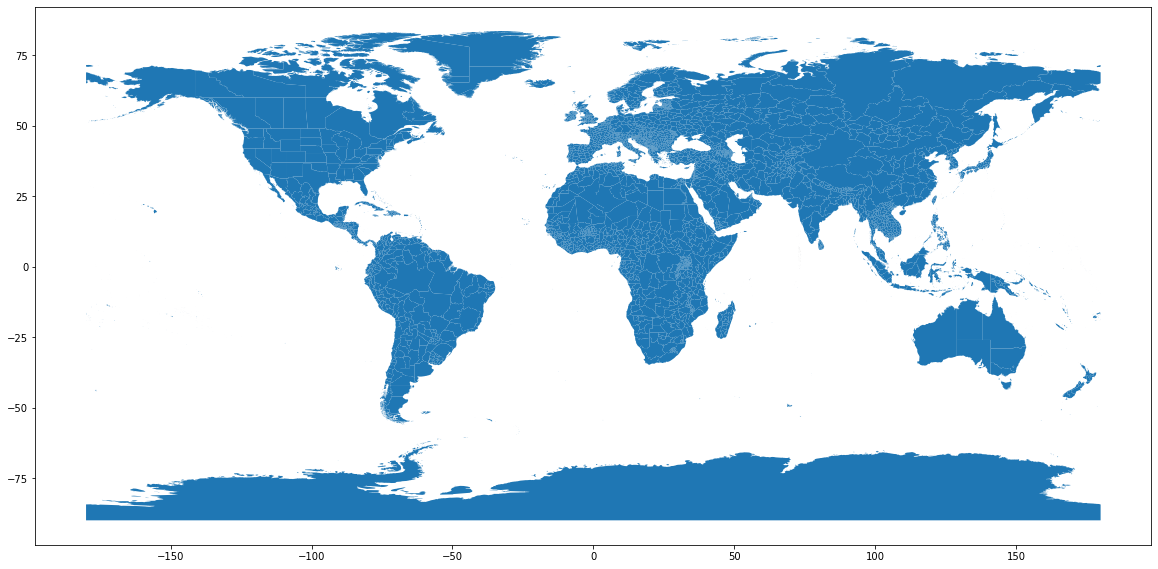

In [12]:
ax = natural_earth.plot(figsize=(20,20))

In [13]:
states = natural_earth[natural_earth.iso_a2 == 'US'] #filters map down to just US States

#### Below is where we can choose the period of time we want to look at in years: ('2018') or months: ('2018-10'):

In [14]:
state_images = label_join(image_metadata_gdf)
state_images_timestamp = state_images[state_images['timestamp'].str.contains('2019', na=False, case=True)]

#### Here we see how many images were taken in each state for the given timeframe above (states not printed if they have no images):

In [15]:
state_counter = {}
state_names = []

for i in state_images_timestamp.name_en:
    state_names.append(i)

for i in state_names:
    if i not in state_counter:
        state_counter[i] = state_names.count(i)
        
print(state_counter) 

{'Minnesota': 197, 'Washington': 1035, 'Idaho': 29, 'Montana': 19, 'North Dakota': 1929, 'Michigan': 557, 'Maine': 934, 'Ohio': 1085, 'New Hampshire': 847, 'New York': 651, 'Vermont': 128, 'Pennsylvania': 340, 'Arizona': 125, 'California': 2564, 'New Mexico': 72, 'Texas': 2631, 'Louisiana': 521, 'Mississippi': 1327, 'Alabama': 11, 'Florida': 824, 'Georgia': 32, 'South Carolina': 36, 'North Carolina': 2345, 'Virginia': 270, 'Maryland': 114, 'Delaware': 20, 'New Jersey': 154, 'Connecticut': 241, 'Rhode Island': 28, 'Massachusetts': 1298, 'Oregon': 1250, 'Nevada': 3640, 'Colorado': 331, 'South Dakota': 88, 'Nebraska': 1160, 'Kansas': 3328, 'Oklahoma': 3470, 'Iowa': 1416, 'Missouri': 1707, 'Wisconsin': 2025, 'Illinois': 3436, 'Kentucky': 737, 'Arkansas': 6845, 'Tennessee': 1113, 'West Virginia': 75, 'Indiana': 2894}


#### Taking the values above we get the highest value and then divide that by three to classify each state by the number of images

In [16]:
max_value=0
for i in state_counter.values():
    if i > max_value:
        max_value = i
        
low = int(max_value / 3)
mid = int(low * 2)
high = int(max_value)

print('Low: ', low, '\nMid: ', mid, '\nHigh: ', high)

Low:  2281 
Mid:  4562 
High:  6845


#### Now that we have three different values we will split the states up and assign them a value (low, mid, high)

In [17]:
low_states = []
mid_states = []
high_states = []

for i in state_counter.keys():
    val = state_counter.get(i)
    if val <= low:
        low_states.append(i)
    if val > low and val < high:
        mid_states.append(i)
    if val >= high:
        high_states.append(i)
        
print('Low: ', low_states, '\n\n\nMid: ', mid_states, '\n\n\nHigh: ', high_states)

Low:  ['Minnesota', 'Washington', 'Idaho', 'Montana', 'North Dakota', 'Michigan', 'Maine', 'Ohio', 'New Hampshire', 'New York', 'Vermont', 'Pennsylvania', 'Arizona', 'New Mexico', 'Louisiana', 'Mississippi', 'Alabama', 'Florida', 'Georgia', 'South Carolina', 'Virginia', 'Maryland', 'Delaware', 'New Jersey', 'Connecticut', 'Rhode Island', 'Massachusetts', 'Oregon', 'Colorado', 'South Dakota', 'Nebraska', 'Iowa', 'Missouri', 'Wisconsin', 'Kentucky', 'Tennessee', 'West Virginia'] 


Mid:  ['California', 'Texas', 'North Carolina', 'Nevada', 'Kansas', 'Oklahoma', 'Illinois', 'Indiana'] 


High:  ['Arkansas']


#### Now we will make a GDF from each of the arrays so that they can be plotted different colors based on their number of images:

In [18]:
low_states_df = pd.DataFrame(low_states, columns=['name'])
mid_states_df = pd.DataFrame(mid_states, columns=['name'])
high_states_df = pd.DataFrame(high_states, columns=['name'])

In [19]:
low_states_gdf = merger(low_states_df, 'name')
mid_states_gdf = merger(mid_states_df, 'name')
high_states_gdf = merger(high_states_df, 'name')

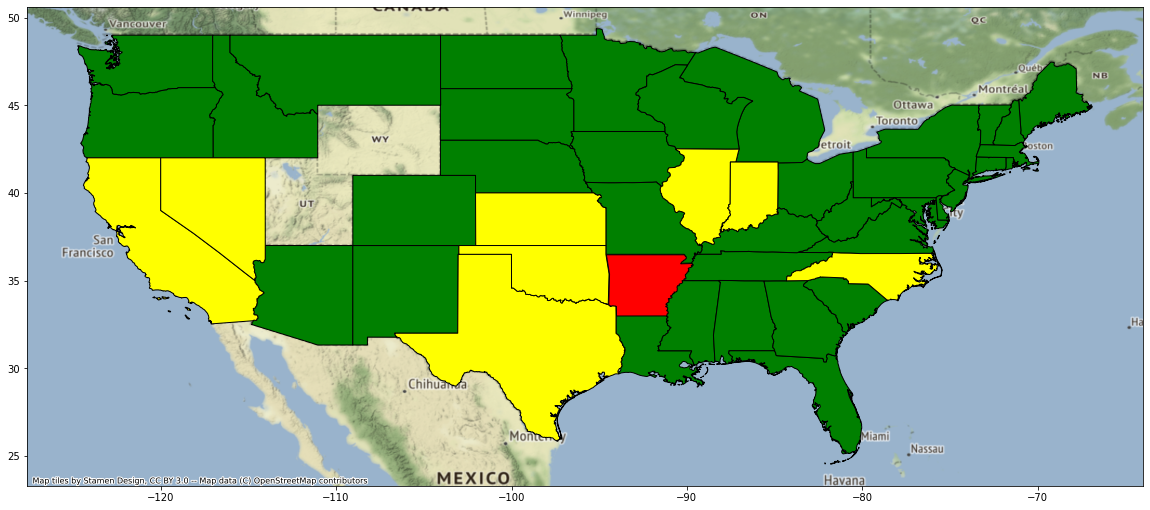

In [20]:
ax = low_states_gdf.plot(figsize=(20,20), color='green', edgecolor='black')
mid_states_gdf.plot(ax=ax, figsize=(20,20), color='yellow', edgecolor='black')
high_states_gdf.plot(ax=ax, figsize=(20,20), color='red', edgecolor='black')
ctx.add_basemap(ax, crs = fiona.crs.from_epsg(4326))
plt.show()

In [21]:
low_states_count = {}
mid_states_count = {}
high_states_count = {}

for i in state_counter.keys():
    val = state_counter.get(i)
    if val <= low:
        low_states_count[i] = val
    if val > low and val < high:
        mid_states_count[i] = val
    if val >= high:
        high_states_count[i] = val
        
print('Low: ', low_states_count, '\n\n\nMid: ', mid_states_count, '\n\n\nHigh: ', high_states_count)

Low:  {'Minnesota': 197, 'Washington': 1035, 'Idaho': 29, 'Montana': 19, 'North Dakota': 1929, 'Michigan': 557, 'Maine': 934, 'Ohio': 1085, 'New Hampshire': 847, 'New York': 651, 'Vermont': 128, 'Pennsylvania': 340, 'Arizona': 125, 'New Mexico': 72, 'Louisiana': 521, 'Mississippi': 1327, 'Alabama': 11, 'Florida': 824, 'Georgia': 32, 'South Carolina': 36, 'Virginia': 270, 'Maryland': 114, 'Delaware': 20, 'New Jersey': 154, 'Connecticut': 241, 'Rhode Island': 28, 'Massachusetts': 1298, 'Oregon': 1250, 'Colorado': 331, 'South Dakota': 88, 'Nebraska': 1160, 'Iowa': 1416, 'Missouri': 1707, 'Wisconsin': 2025, 'Kentucky': 737, 'Tennessee': 1113, 'West Virginia': 75} 


Mid:  {'California': 2564, 'Texas': 2631, 'North Carolina': 2345, 'Nevada': 3640, 'Kansas': 3328, 'Oklahoma': 3470, 'Illinois': 3436, 'Indiana': 2894} 


High:  {'Arkansas': 6845}
